# Computational Quantum Physics & Applications
## _Shannon Entropy & Info Content in RHF Atomic Densities (Z = 2–10)_
_Eleftherios Marios Zografos_   
_A.E.M : 4428_

# 1) Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.special import spherical_jn
from scipy.integrate import simpson
from scipy.stats import linregress

## 2) Loading RHF Slater‐Type Orbital Data

We store the pre‐computed RHF contraction information for each atom in a single Excel file, with one worksheet per element (He through Ne).  After reading the file, each sheet yields a DataFrame with these columns:

- **element**:  Atomic symbol (e.g.\ `He`, `Li`, …)  
- **Z**:        Nuclear charge (integer)  
- **orbital**:  Orbital label (e.g.\ `1s`, `2p`)  
- **slater**:   Primitive designation (e.g.\ `1S`, `2P`)  
- **exponent**: Slater exponent $Z_{j\ell}$ for each primitive  
- **coefficient**: Contraction weight $C_{j n\ell}$

By iterating over each sheet’s DataFrame, we reconstruct the full radial wavefunction
$$
R(r)\;=\;\sum_{j}C_{j n\ell}\,N_{j n\ell}\,r^{n-1}e^{-Z_{j n\ell}r}
$$
for every occupied orbital.  These $(R(r)$ values feed directly into our density, entropy, and divergence calculations.

In [2]:
# Read in all elements (each sheet is one atom)
rhf = pd.read_excel("RHF.xlsx", sheet_name=None)
elements = list(rhf.keys())
print("Loaded elements:", elements)

Loaded elements: ['He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne']


# 3) Helper Functions
Define all of our low‐level routines for building Slater‐orbitals, computing densities, etc.

In [3]:
def NCoeff(n : np.ndarray , Z: np.ndarray) -> np.ndarray :
    """
    Compute normalization coefficient for each Slater primitive:
    (2*Z)^(n + 0.5) / sqrt((2n)!)
    """

    return (2*Z)**(n+0.5)/np.sqrt(factorial(2*n))

In [4]:
def SlaterR(n: np.ndarray, Z: np.ndarray, r: np.ndarray) -> np.ndarray:
    """
    Build the radial part of each contracted STO:
      S_jl(r) = N_jl * r^(n_jl - 1) * exp(-Z_jl * r)
    Returns an array of shape (len(r), len(n)).
    """
    Z = np.asarray(Z)
    N = NCoeff(n, Z)
    # each column is one primitive
    return N * r[:, None]**(n - 1) * np.exp(-Z[None, :] * r[:, None])

In [5]:
def slater2n(slater: pd.Series) -> np.ndarray:
    """
    Extract the principal quantum number n from a '1S', '2P', ... string.
    Assumes slater.str[0] is the digit.
    """
    return slater.str[0].astype(int).to_numpy()

In [6]:
def electronDistr(Z: int, orbit: str) -> tuple[int,int]:
    """
    Given remaining nuclear charge Z and orbital label ('1s','2p',...),
    return (number_of_electrons_in_that_orbital, new_remaining_Z).
    """
    if orbit[1] == 's':
        n_occ = min(2, Z)
        return n_occ, Z - n_occ
    else:  # 'p'
        n_occ = min(6, Z)
        return n_occ, Z - n_occ

# 4) Compute $ρ(r)\, \&\,  n(k)$

In [7]:
# Precompute grids
r = np.linspace(1e-8, 60, 5000)
k = np.linspace(1e-8, 150, 5000)
kr = np.outer(k, r)
jv = {'s': spherical_jn(0, kr), 'p': spherical_jn(1, kr)}

In [8]:
def FindP(element: pd.DataFrame, r: np.ndarray, k: np.ndarray, jv: dict):
    """
    Given one element's RHF sheet, build:
      - pr(r): radial probability in coordinate space
      - nk(k): radial probability in momentum space
    Returns: pr, nk
    """
    pr = np.zeros_like(r)
    nk = np.zeros_like(k)
    Z_remain = element.Z.iloc[0]

    for orb in element.orbital.unique():
        df = element[element.orbital == orb]
        n = slater2n(df.slater)
        S_vals = SlaterR(n, df.exponent.to_numpy(), r) # shape (Nr, primitives)
        R_r    = (df.coefficient.to_numpy()[None, :] * S_vals).sum(axis=1)
        R_k    = 4*np.pi * simpson(R_r[None, :] * jv[orb[1]] * r**2, r, axis=1)

        occ, Z_remain = electronDistr(Z_remain, orb)
        pr += occ * R_r**2
        nk += occ * R_k**2

    # normalize each to unit integral
    pr /= 4*np.pi * simpson(pr * r**2, r)
    nk /= 4*np.pi * simpson(nk * k**2, k)
    return pr, nk

# 5) Information Measures
Compute Shannon entropies $S_r \, \& \, S_k$, $S_{max}$, Onicescu $O$, Fisher $I$, order $\Omega$

In [9]:
# Preallocate results
nZ = len(elements)
Sr        = np.zeros(nZ)
Sk        = np.zeros(nZ)
O         = np.zeros(nZ)
Iinfo     = np.zeros(nZ)
Omega     = np.zeros(nZ)
Smax_arr  = np.zeros(nZ)

pr_values = np.zeros((nZ, r.size))
nk_values = np.zeros((nZ, k.size))

In [10]:
for i, Zsym in enumerate(elements):
    pr, nk = FindP(rhf[Zsym], r, k, jv)

    # store for later
    pr_values[i, :] = pr
    nk_values[i, :] = nk

    # -- Shannon entropies --
    Sr[i] = -4*np.pi * simpson(pr * np.log(pr + 1e-30) * r**2, r)
    Sk[i] = -4*np.pi * simpson(nk * np.log(nk + 1e-30) * k**2, k)

    # -- Onicescu measure O = 1/(E_r E_k) --
    Er = 4*np.pi * simpson(pr**2 * r**2, r)
    Ek = 4*np.pi * simpson(nk**2 * k**2, k)
    O[i] = 1.0 / (Er * Ek)

    # -- Fisher information --
    dpdr = np.gradient(pr, r)
    Iinfo[i] = 4*np.pi * simpson((dpdr**2 / pr) * r**2, r)

    # -- Variance‐dependent Smax --
    avgr2    = 4*np.pi * simpson(pr * r**4, r)
    kin      = 4*np.pi * simpson(nk * k**4, k)
    Smax_i   = 3*(1 + np.log(np.pi)) + 1.5 * np.log((4.0/9.0) * avgr2 * kin)
    Smax_arr[i] = Smax_i

    # -- Order parameter Ω --
    Ssum = Sr[i] + Sk[i]
    Omega[i] = 1.0 - Ssum / Smax_i

# 6) Plotting & Tables
Visualize results and compare with theory

In [11]:
calculated_values = pd.DataFrame({
    "Z": np.arange(2, 2+nZ),
    "Sr": Sr, "Sk": Sk, "S": Sr+Sk, "Smax":Smax_arr,
    "O": O,  "I": Iinfo,  "Ω": Omega
}, index=elements)
calculated_values

,Z,Sr,Sk,S,Smax,O,I,Ω
He,2,2.698508,3.913415,6.611923,7.049306,100.361884,11.454178,0.062046
Li,3,3.701437,3.996822,7.698259,10.357876,9.157066,19.215893,0.256772
Be,4,3.623855,4.190193,7.814047,10.395109,8.454199,27.401481,0.248296
B,5,3.405437,4.705913,8.111350,10.373994,15.964618,35.197331,0.218107
C,6,3.106013,5.156601,8.262614,10.262665,25.709658,42.863441,0.194886
N,7,2.801667,5.549377,8.351044,10.152339,37.425422,50.495983,0.177427
O,8,2.550506,5.867411,8.417917,10.111782,48.469644,58.190730,0.167514
F,9,2.298780,6.163409,8.462190,10.053962,61.117092,65.928619,0.158323
Ne,10,2.055072,6.437178,8.492251,9.991642,75.194302,73.749726,0.150065


In [12]:
# 1) Load theoretical values (only contains Sr, Sk, Smax, Ω, O)
theoritical_values = pd.read_excel("RHF_Theoritical.xlsx").set_index("element")
theoritical_values

,Z,Sr,Sk,S,Smax,Ω,O
element,,,,,,,
He,2,2.69851,3.91342,6.61193,7.0493,0.06204,100.36100
Li,3,3.70144,3.99682,7.69826,10.3578,0.25677,9.15713
Be,4,3.62386,4.19019,7.81405,10.3950,0.24829,8.45434
B,5,3.40545,4.70590,8.11135,10.3738,0.21810,15.96530
C,6,3.10602,5.15658,8.26260,10.2624,0.19492,25.71210
N,7,2.80169,5.54934,8.35103,10.1520,0.17740,37.43200
O,8,2.55054,5.86737,8.41791,10.1113,0.16747,48.48340
F,9,2.29883,6.16333,8.46215,10.0533,0.15827,61.14500
Ne,10,2.05514,6.43707,8.49221,9.9908,0.14999,75.24470


In [13]:
# 2) Identify which columns overlap between calculated and theoretical
common = [c for c in calculated_values.columns if c in theoritical_values.columns]
# 3) Compute absolute % error
absolute_error = (
    (calculated_values[common] - theoritical_values[common])
      .abs()
      * 100
)
# 4) (Optionally) reorder columns to a preferred sequence
absolute_error = absolute_error[common]

# 5) Display
absolute_error

,Z,Sr,Sk,S,Smax,O,Ω
He,0,0.000198,0.000549,0.000747,0.000556,0.088387,0.000626
Li,0,0.000342,0.000226,0.000116,0.007580,0.006444,0.000243
Be,0,0.000550,0.000258,0.000291,0.010921,0.014056,0.000582
B,0,0.001313,0.001339,0.000026,0.019374,0.068218,0.000727
C,0,0.000748,0.002148,0.001401,0.026509,0.244226,0.003387
N,0,0.002271,0.003710,0.001439,0.033850,0.657820,0.002652
O,0,0.003410,0.004131,0.000720,0.048245,1.375640,0.004401
F,0,0.004972,0.007937,0.003965,0.066234,2.790785,0.005292
Ne,0,0.006760,0.010836,0.004076,0.084168,5.039761,0.007452


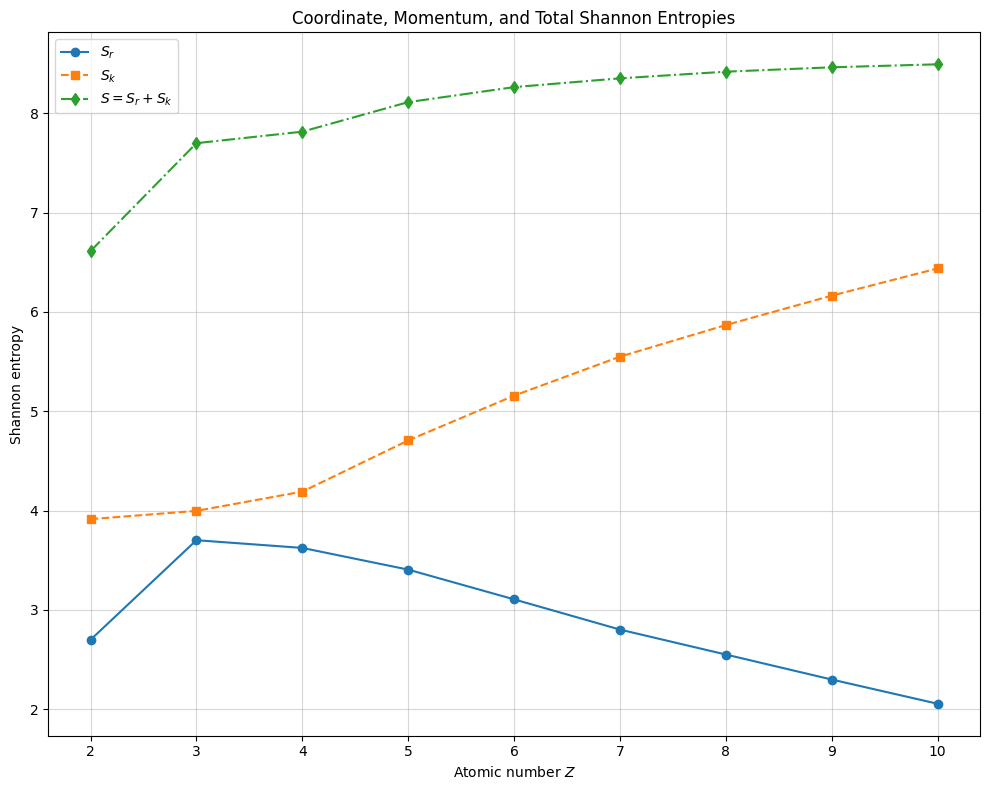

In [14]:
# Sr, Sk, and S on one figure
plt.figure(figsize=(10,8))
plt.plot(calculated_values.Z, calculated_values.Sr, 'o-', label=r'$S_r$')
plt.plot(calculated_values.Z, calculated_values.Sk, 's--', label=r'$S_k$')
plt.plot(calculated_values.Z, calculated_values.S, 'd-.', label=r'$S = S_r + S_k$')
plt.xlabel('Atomic number $Z$')
plt.ylabel('Shannon entropy')
plt.title('Coordinate, Momentum, and Total Shannon Entropies')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

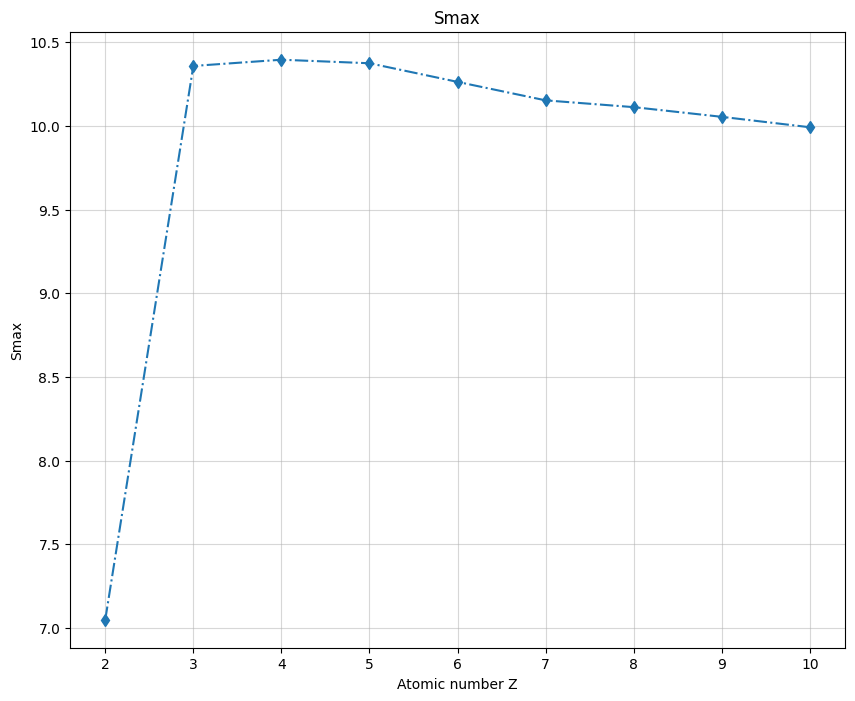

In [15]:
# Plot Smax
plt.figure(figsize=(10,8))
plt.plot(calculated_values.Z, calculated_values["Smax"], 'd-.')
plt.xlabel('Atomic number Z')
plt.ylabel('Smax')
plt.title('Smax')
plt.grid(alpha=0.5)
plt.show()

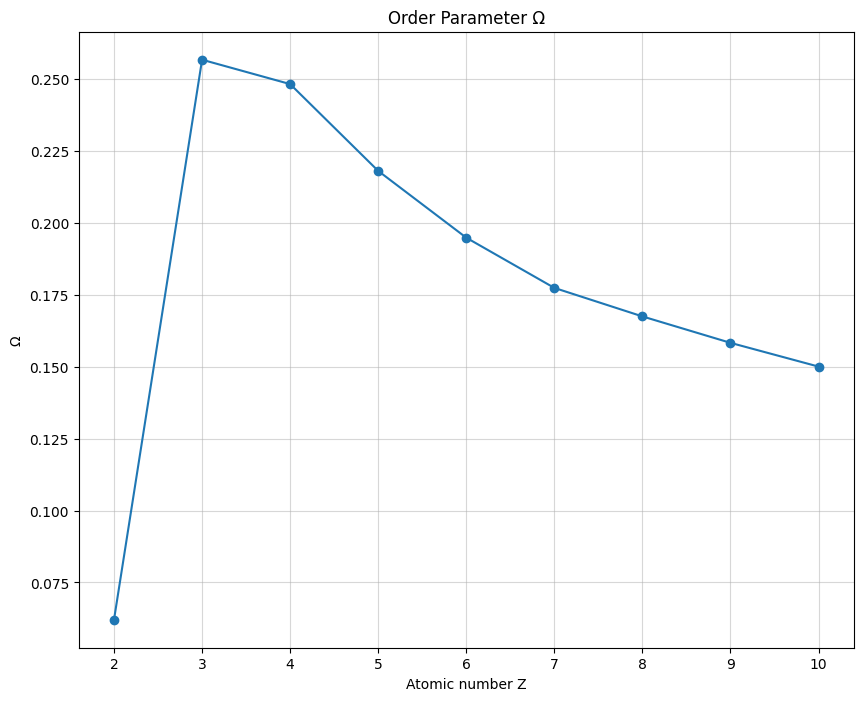

In [16]:
# Plot Omega
plt.figure(figsize=(10,8))
plt.plot(calculated_values.Z, calculated_values["Ω"], 'o-')
plt.xlabel('Atomic number Z')
plt.ylabel('Ω')
plt.title('Order Parameter Ω')
plt.grid(alpha=0.5)
plt.show()

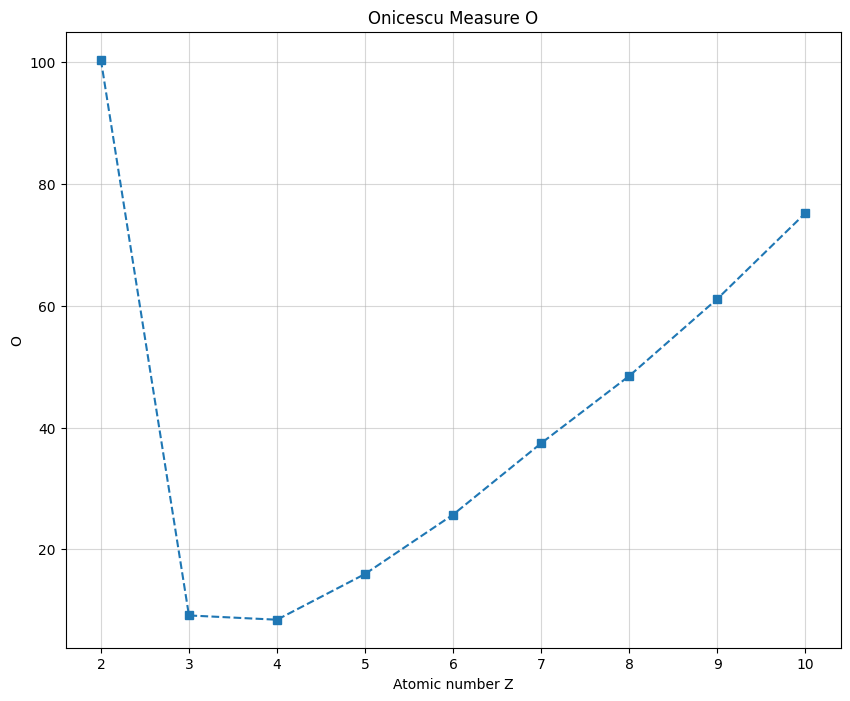

In [17]:
# Plot O
plt.figure(figsize=(10,8))
plt.plot(calculated_values.Z, calculated_values["O"], 's--')
plt.xlabel('Atomic number Z')
plt.ylabel('O')
plt.title('Onicescu Measure O')
plt.grid(alpha=0.5)
plt.show()


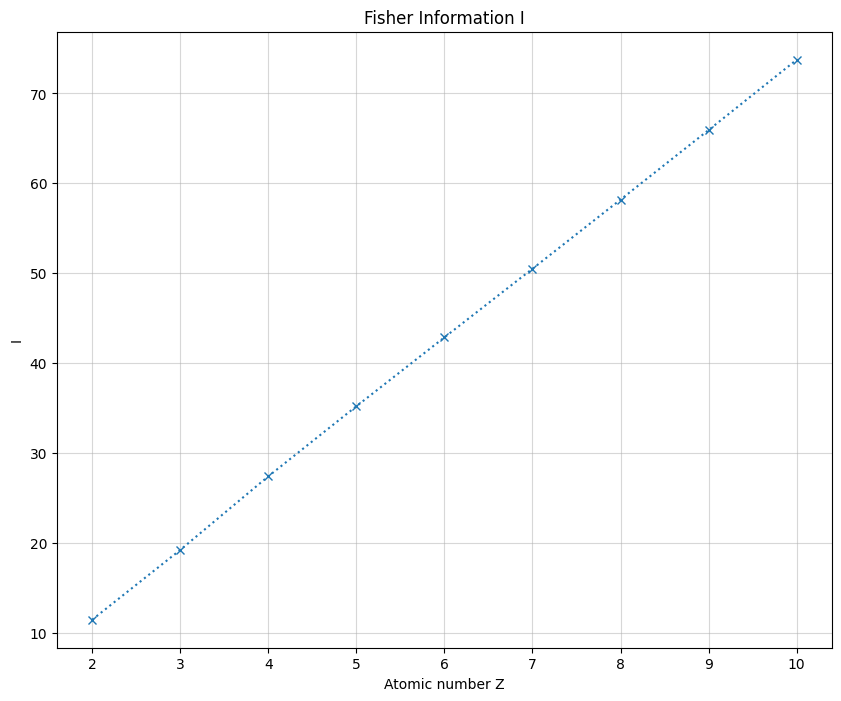

In [18]:
# Plot Fisher I
plt.figure(figsize=(10,8))
plt.plot(calculated_values.Z, calculated_values["I"], 'x:')
plt.xlabel('Atomic number Z')
plt.ylabel('I')
plt.title('Fisher Information I')
plt.grid(alpha=0.5)
plt.show()

## 7) Ionization‐Model Divergences

Here we build a single‐electron, hydrogenic reference density from the first ionization potential (IP) and compute:

- the symmetrized Kullback–Leibler divergence $K_{\rm ion}$ between the RHF radial density $p_r$ and the reference density $p_2$, and  
- the corresponding Jensen–Shannon divergence $J_{\rm ion}$.

The reference **hydrogenic 1s** radial density is given by
$$
p_2(r)
= \frac{(2I_p)^{3/2}}{\pi} \exp\bigl(-2\sqrt{2I_p}\,r\bigr),
$$
where $I_p$ is the first ionization potential in atomic units.  This is normalized so that
$$
4\pi \int_{0}^{\infty} p_2(r)\,r^2\,dr = 1.
$$




In [19]:
# First‐ionization potentials in eV
ip_ev = {
    2: 24.5874,   # He
    3: 5.3917,    # Li
    4: 9.3227,    # Be
    5: 8.2980,    # B
    6: 11.2603,   # C
    7: 14.5341,   # N
    8: 13.6181,   # O
    9: 17.4228,   # F
   10: 21.5645    # Ne
}

In [20]:
def compute_ionization_measures(pr, r, ip_eV):
    """
    Given:
      pr(r)    : normalized radial density array on grid r
      r        : 1D array of radii (same length as pr)
      ip_eV    : first ionization potential in eV
    Returns:
      K_ion    : symmetrized KL divergence vs hydrogenic ref.
      J_ion    : Jensen-Shannon divergence vs same reference
    """
    # 1) Convert IP to atomic units and build decay constant
    ip_au = ip_eV / 27.212
    lam   = np.sqrt(2 * ip_au)

    # 2) Reference hydrogen‐like 1s density
    #    p2(r) ∝ (2 IP)^(3/2)/π * exp(-2*sqrt(2IP)*r)
    p2 = (2*ip_au)**1.5/np.pi * np.exp(-2*lam * r)

    # 3) Symmetrized KL divergence
    integrand1 = pr * np.log(pr / p2) * r**2
    integrand2 = p2 * np.log(p2 / pr) * r**2
    K_ion = 4*np.pi * (simpson(integrand1, r) + simpson(integrand2, r))

    # 4) Jensen–Shannon divergence
    m = 0.5*(pr + p2)
    Hm = -4*np.pi * simpson(m * np.log(m + 1e-30) * r**2, r)
    Hr = -4*np.pi * simpson(pr* np.log(pr + 1e-30) * r**2, r)
    H2 = -4*np.pi * simpson(p2* np.log(p2 + 1e-30) * r**2, r)
    J_ion = Hm - 0.5*Hr - 0.5*H2

    return K_ion, J_ion

In [21]:
# Pre‐allocate arrays and fill them
K_ion = np.zeros_like(Sr)
J_ion = np.zeros_like(Sr)

for i, Z in enumerate(calculated_values.Z):
    pr_i = pr_values[i]
    K_ion[i], J_ion[i] = compute_ionization_measures(pr_i, r, ip_ev[int(Z)])

# Append to the master DataFrame
calculated_values["KL_ion"] = K_ion
calculated_values["JS_ion"] = J_ion


calculated_values[["KL_ion","JS_ion"]]

,KL_ion,JS_ion
He,0.103815,0.012838
Li,1.626170,0.171920
Be,1.050910,0.112857
B,0.909266,0.090052
C,0.730961,0.072690
N,0.627101,0.062956
O,0.799589,0.080193
F,0.701856,0.071700
Ne,0.638121,0.066264


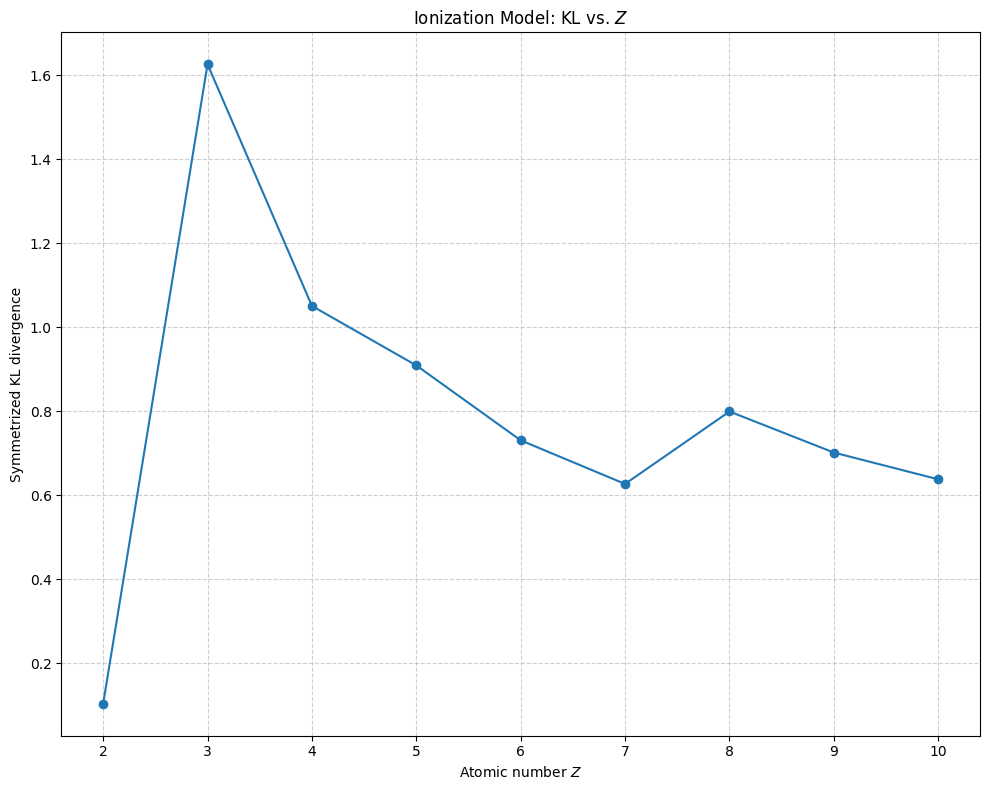

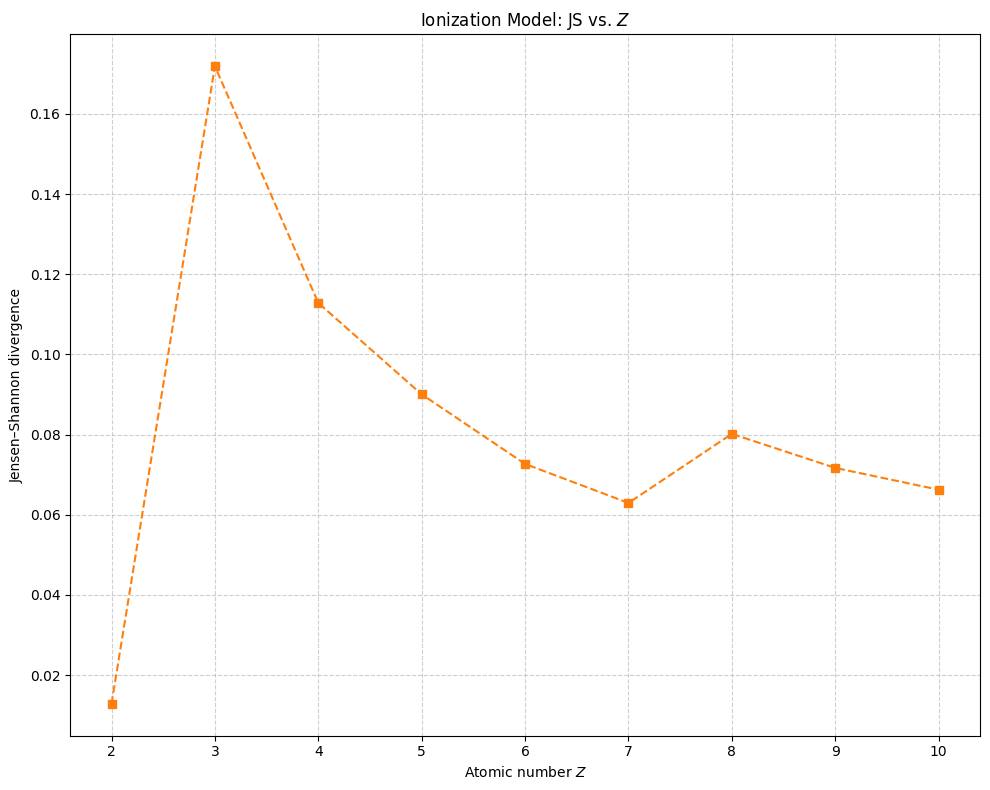

In [22]:
Z = calculated_values["Z"].values

# Plot KL divergence alone
plt.figure(figsize=(10,8))
plt.plot(Z, calculated_values["KL_ion"], 'o-', label="KL$_{\\rm ion}$")
plt.xlabel("Atomic number $Z$")
plt.ylabel("Symmetrized KL divergence")
plt.title("Ionization Model: KL vs. $Z$")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Plot JS divergence alone
plt.figure(figsize=(10,8))
plt.plot(Z, calculated_values["JS_ion"], 's--', label="JS$_{\\rm ion}$", color='C1')
plt.xlabel("Atomic number $Z$")
plt.ylabel("Jensen–Shannon divergence")
plt.title("Ionization Model: JS vs. $Z$")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# 8) Thomas–Fermi model Divergences :

$$
p_{3}(r)\;\propto\;
\frac{Z^{\tfrac32}}{r^{\tfrac32}}
\;\left[\,1 + \bigl(a\,r\,Z^{\tfrac13}\bigr)^{0.772}\right]^{-5.829}\,.
$$


which we normalize to $p_4(r)$.  We then compute the same $K$ and $J$ divergences.

In [23]:
def compute_TF_divergences(pr, r, Z):
    """
    Given:
      pr(r) : normalized RHF radial density on grid r
      r     : radii grid
      Z     : atomic number
    Returns:
      K_TF  : symmetrized KL divergence vs TF
      JS_TF : Jensen-Shannon divergence vs TF
    """
    # a) build un‐normalized TF density p3(r)
    a = 1/4.6405
    prefactor = 2**1.5 * Z**1.5
    x = a * r * Z**(1/3)
    p3 = prefactor * r**(-1.5) * (1 + x**0.772)**(-5.829) / (3*np.pi**2)

    # b) normalize: 4π ∫ p4 r^2 dr = 1
    cc = 4*np.pi * simpson(p3 * r**2, r)
    p4 = p3 / cc

    # c) symmetrized KL
    i1 = pr * np.log(pr/p4 + 1e-30) * r**2
    i2 = p4 * np.log(p4/pr + 1e-30) * r**2
    K_TF = 4*np.pi * (simpson(i1, r) + simpson(i2, r))

    # d) Jensen–Shannon
    m = 0.5*(pr + p4)
    Hm = -4*np.pi * simpson(m * np.log(m + 1e-30) * r**2, r)
    Hr = -4*np.pi * simpson(pr* np.log(pr + 1e-30) * r**2, r)
    H4 = -4*np.pi * simpson(p4* np.log(p4 + 1e-30) * r**2, r)
    JS_TF = Hm - 0.5*Hr - 0.5*H4

    return K_TF, JS_TF

In [24]:
K_TF = np.zeros_like(Sr)
JS_TF = np.zeros_like(Sr)

for i, Z in enumerate(calculated_values.Z):
    pr_i = pr_values[i]
    K_TF[i], JS_TF[i] = compute_TF_divergences(pr_i, r, int(Z))

# append
calculated_values["KL_TF"] = K_TF
calculated_values["JS_TF"] = JS_TF

calculated_values[["KL_TF","JS_TF"]]

,KL_TF,JS_TF
He,2.983173,0.121524
Li,0.529603,0.045431
Be,0.633849,0.044475
B,0.641520,0.043681
C,0.769516,0.046265
N,0.916005,0.050299
O,0.968568,0.052571
F,1.069852,0.056295
Ne,1.195056,0.060890


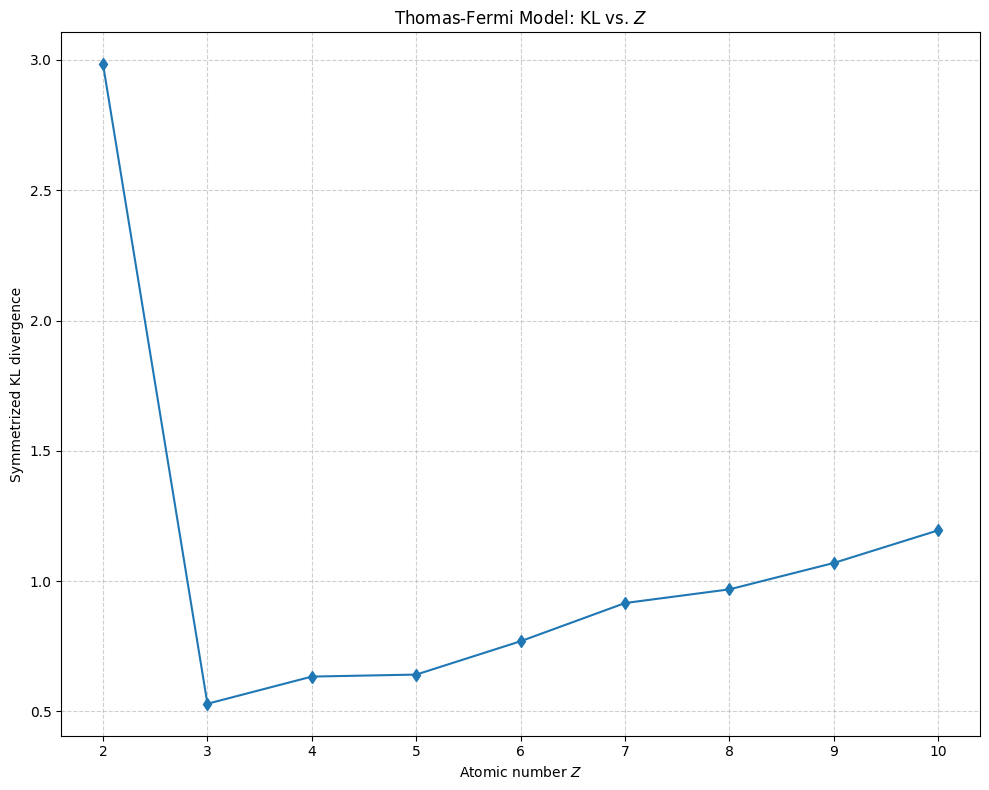

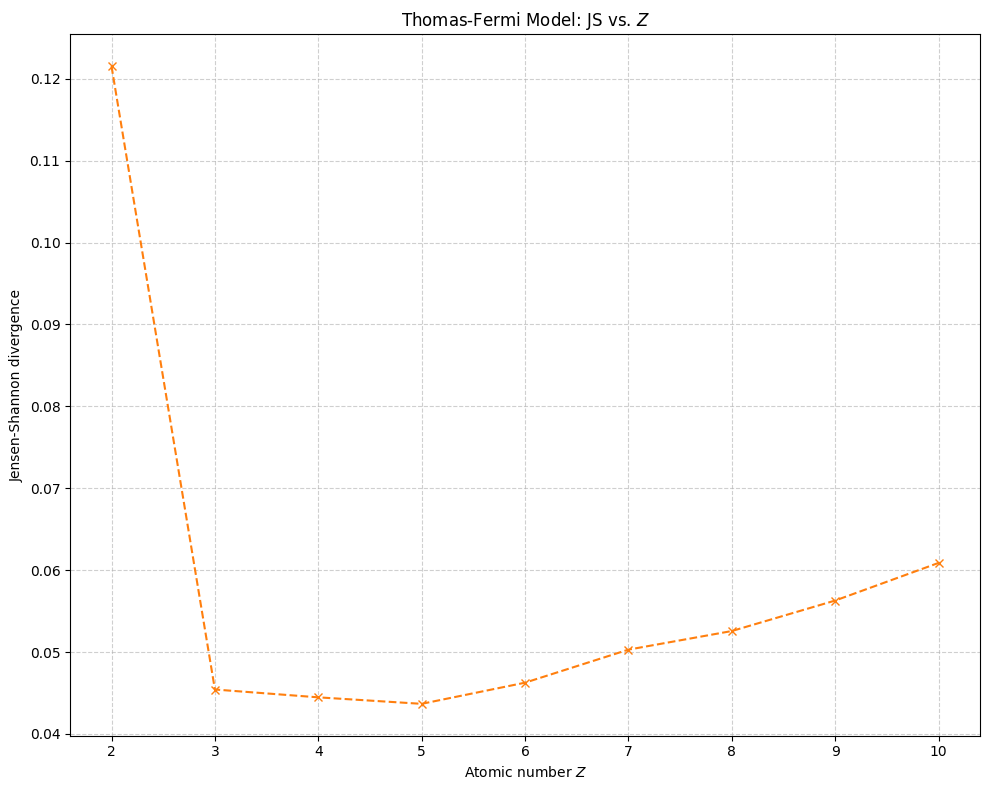

In [25]:
Z = calculated_values["Z"].values

# Plot KL_TF alone
plt.figure(figsize=(10,8))
plt.plot(Z, calculated_values["KL_TF"], 'd-', label="KL$_{\\rm TF}$")
plt.xlabel("Atomic number $Z$")
plt.ylabel("Symmetrized KL divergence")
plt.title("Thomas-Fermi Model: KL vs. $Z$")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Plot JS_TF alone
plt.figure(figsize=(10,8))
plt.plot(Z, calculated_values["JS_TF"], 'x--', label="JS$_{\\rm TF}$", color='C1')
plt.xlabel("Atomic number $Z$")
plt.ylabel("Jensen-Shannon divergence")
plt.title("Thomas-Fermi Model: JS vs. $Z$")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## Exponential Fit of Total Shannon Entropy

We load the tabulated total Shannon entropy $S$ from `Z_vs_S.xlsx` and fit it to the form

$$
S(Z) \;=\; a \,+\,b\ln\bigl(Z\bigr).
$$

Using `scipy.optimize.curve_fit` we obtain the best‐fit parameters $a$ and $b$, along with the coefficient of determination $R^2$.


S(Z) ≈ 1.046·ln(Z) + 6.330,  R² = 0.9895


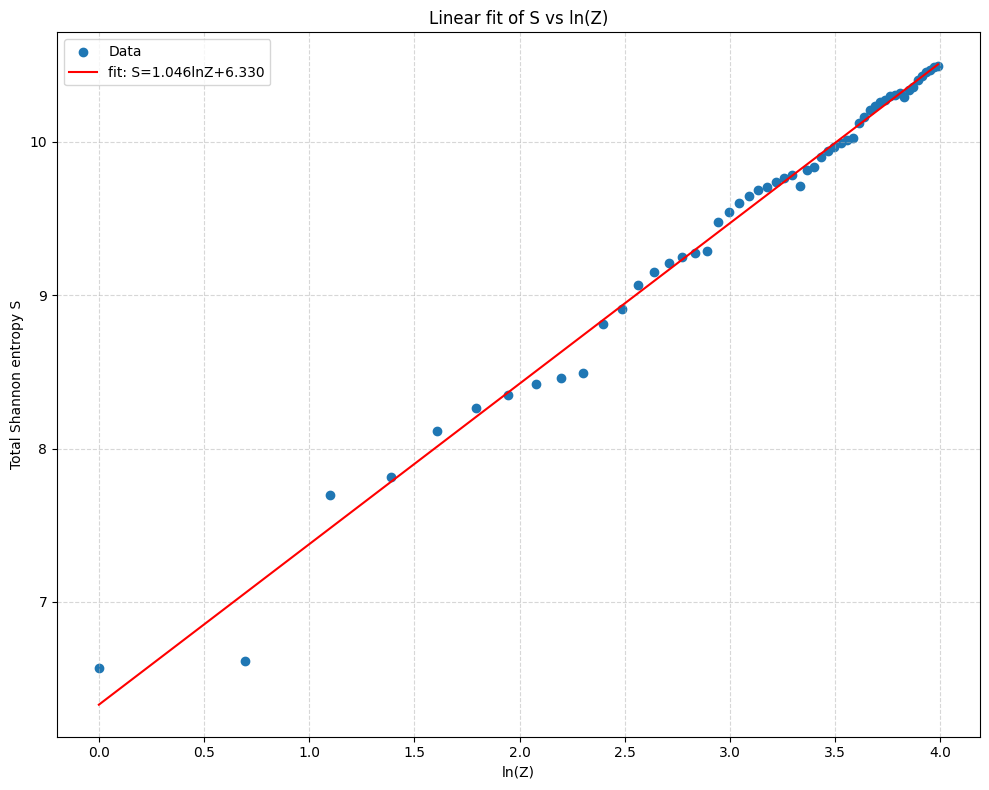

In [26]:
# 1) Load Z vs S data
df = pd.read_excel("Z_vs_S.xlsx")
Z = df["Z"].values
S = df["S"].values

# 1) take logs
logZ = np.log(Z)

# 2) linear regression: S ~ m*logZ + c
m, c, r_value, p_value, stderr = linregress(logZ, S)
print(f"S(Z) ≈ {m:.3f}·ln(Z) + {c:.3f},  R² = {r_value**2:.4f}")

# 3) plot
plt.figure(figsize=(10,8))
plt.scatter(logZ, S, label="Data")
plt.plot(logZ, m*logZ + c, 'r-', label=f"fit: S={m:.3f}lnZ+{c:.3f}")
plt.xlabel("ln(Z)")
plt.ylabel("Total Shannon entropy S")
plt.title("Linear fit of S vs ln(Z)")
plt.legend(); plt.grid(ls='--',alpha=0.5)
plt.tight_layout()
plt.show()